# **LoopsResultsExploration**

## **1. Importing and First Proccesing**

In [23]:
import pandas as pd
from matplotlib import pyplot as plt
from DataCleaning import *

pd.options.display.max_columns = 50

In [24]:
raw_data = pd.read_excel(cleaning_config['raw_data_path'])

# partial cleaning
drop_columns(raw_data, cleaning_config['unnecessary_columns'])
convert_types(raw_data, cleaning_config['type_conversions'])
raw_data = drop_first_loop(raw_data)
raw_data = drop_first_line(raw_data)

--drop_first_loop: 1298 rows were filtered out.
--drop_first_line: 4219 rows were filtered out.


In [25]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5071 entries, 7 to 10586
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   subject                       5071 non-null   object 
 1   step_num                      5071 non-null   int64  
 2   uid                           5071 non-null   int64  
 3   trial_start_time              5071 non-null   int64  
 4   rt                            5071 non-null   int32  
 5   response                      5071 non-null   object 
 6   loop_step                     5071 non-null   int32  
 7   trial_order                   5071 non-null   int64  
 8   var_mapping                   5071 non-null   object 
 9   trial_set                     5071 non-null   int64  
 10  trial                         5071 non-null   int64  
 11  core_program                  5071 non-null   int64  
 12  variant                       5071 non-null   object 
 13  st

In [26]:
raw_data.sample(3)

,subject,step_num,uid,trial_start_time,rt,response,loop_step,trial_order,var_mapping,trial_set,trial,core_program,variant,step_id,text1,response_needed,expected_response,is_loop,loop_type,loop_type_switch,n_iterations,n_loop_lines,expected_response_whole_loop,step_type,prev_loop_type,correct,same_as_prev_loop_type
7454,102B,100,78,418827,2809,4,1,3,1=a;2=i,2,1009,5,FWWFFFWW,6,"for i in [1, 2]:\n a *= 3\n a -= 11",True,4.0,True,for,False,2,2,"[15, 4, 12, 1]",loop,0,True,False
5502,104A,436,59,932954,1108,15,2,12,1=a;2=i,1,1007,4,FWWWFFFW,5,while a <= 10:\n a *= 3\n a -= 1,True,15.0,True,while,False,2,2,"[6, 5, 15, 14]",loop,0,True,False
10262,106A,134,58,535298,3253,3,2,4,1=a;2=i,2,7,4,WFFFWWWF,4,"for i in [1, 2, 3, 4]:\n a = average(a,1)",True,3.0,True,for,False,4,1,"[9, 5, 3, 2]",loop,0,True,False


## **2. Exploring Outliers**

In [27]:
def is_outlier(x, x_q1, x_q3, x_iqr, threshold):
    return (x_q1 - x) / x_iqr >= threshold or (x - x_q3) / x_iqr >= threshold

### 2.1. Response-Time Between Subjects

In [28]:
# filtering only necessary columns
response_times = raw_data[['subject', 'step_num', 'rt']].copy()
response_times.drop_duplicates(inplace=True)

# calculating quantiles and std
g_rt_std = response_times['rt'].std()
g_rt_q1, g_rt_q3 = response_times['rt'].quantile([0.25, 0.75])
g_rt_iqr = g_rt_q3 - g_rt_q1

In [29]:
# checking for outliers in terms of median response time
med_rt_per_subject = response_times[['rt', 'subject']].groupby('subject').median()
med_rt_per_subject.columns = ['med_rt']

med_outlier_mask = med_rt_per_subject['med_rt'].apply(is_outlier, args=(g_rt_q1, g_rt_q3, g_rt_iqr, 1.5))
med_outliers = med_rt_per_subject[med_outlier_mask].index

if med_outliers.size > 0:
    print(f'Seems that: {list(med_outliers)} are outliers in terms of mean response time within subject.')
else:
    print("No Outliers detected! at least in terms of median response time within subject.")

No Outliers detected! at least in terms of median response time within subject.


In [30]:
# checking for outliers in terms of response time variance (standard deviation)
rt_std_per_subject = response_times[['rt', 'subject']].groupby('subject').std()
rt_std_per_subject.columns = ['rt_std']

std_q3, std_q1 = rt_std_per_subject['rt_std'].quantile([0.75, 0.25])
std_iqr = std_q3 - std_q1

std_outlier_mask = rt_std_per_subject['rt_std'].apply(is_outlier, args=(std_q1, std_q3, std_iqr, 1.5))
std_outliers = rt_std_per_subject[std_outlier_mask].index
if std_outliers.size > 0:
    print(f'Seems that: {list(std_outliers)} are outliers in terms of response time variance within subject.')
else:
    print("No Outliers detected! at least in terms of response time variance within subject.")

Seems that: ['103B'] are outliers in terms of response time variance within subject.


In [31]:
print(f'General response time std: {g_rt_std}')
rt_std_per_subject.loc[['103B', '108B']].T

General response time std: 1838.0058363095263


subject,103B,108B
rt_std,2988.853086,2774.760539


#### *It seems that in terms of response time variance within subject, **103B** is an outlier, and **108B** is arguably also an outlier.*

In [32]:
print(f"103B's grade: {(rt_std_per_subject.loc['103B', 'rt_std'] - std_q3) / std_iqr}")
print(f"108B's grade: {(rt_std_per_subject.loc['108B', 'rt_std'] - std_q3) / std_iqr}")

103B's grade: 1.856285494638352
108B's grade: 1.470637240522526


#### *I would not filter 103B and 108B out, because they are not so extreme.*

### 2.2. Mistakes Rate (%) Between Subjects

In [33]:
# filtering only necessary columns
response_success = raw_data[['subject', 'step_num', 'trial', 'correct']].copy()
response_success.drop_duplicates(inplace=True)

# calculating quantiles
g_c_mean = response_success['correct'].mean()
print(f'mean general success rate: {round(g_c_mean, 2)}')

mean general success rate: 0.97


In [34]:
success_per_subject = response_success[['subject', 'correct']].groupby('subject').mean()
success_per_subject.rename(columns={'correct': 'success_rate'}, inplace=True)
success_per_subject.sort_values(by='success_rate', ascending=False).T

subject,103B,105B,108A,106A,107B,106B,108B,104A,104B,105A,109B,102B,102A,103A,109A,101B
success_rate,1.0,1.0,0.995455,0.981818,0.981818,0.977273,0.977273,0.975,0.972727,0.972727,0.963636,0.959091,0.956818,0.940909,0.918182,0.831169


{'whiskers': [<matplotlib.lines.Line2D at 0x1a76fd81010>,
 'caps': [<matplotlib.lines.Line2D at 0x1a76fe8fe10>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a76fd81d50>],
 'medians': [<matplotlib.lines.Line2D at 0x1a76fe81810>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a76fe80fd0>],
 'means': []}

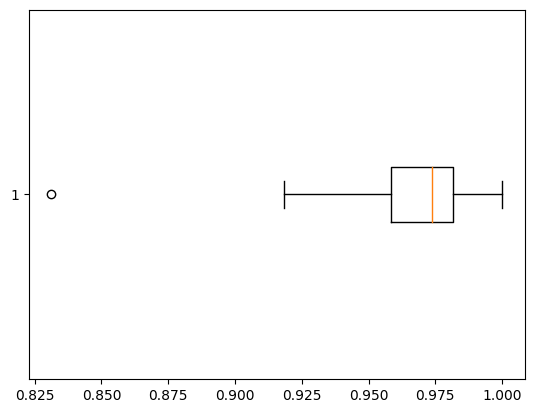

In [66]:
plt.boxplot(success_per_subject, vert=False, whis=2)

#### *Looks like **101B** was significantly unsuccessful, but he should be replaced anyway.*
#### *In addition, .**103B** & **105B** are too successful. I would recommend filtering 103B out since he was also very slow.* 

### 2.3. Trial Mistakes Rate (%)

In [35]:
# calculating response success rate per trial
success_per_trial = response_success[['subject', 'trial', 'correct']].groupby(['subject', 'trial']).mean()
success_per_trial.rename(columns={'correct': 'success_per_trial'}, inplace=True)

success_per_trial.head(3)

success_per_trial
subject trial                   
101B    1               0.900000
        2               0.750000
        5               0.761905

In [36]:
# actually finding the trial outliers in terms of success rate within subject
trial_success_q1, trial_success_q3 = success_per_trial['success_per_trial'].quantile([0.25, 0.75])
trial_success_iqr = trial_success_q1 - trial_success_q3
outlier_trails_mask = success_per_trial['success_per_trial'].apply(is_outlier, args=(trial_success_q1, trial_success_q3, trial_success_iqr, 2))
outlier_trails = success_per_trial[outlier_trails_mask]

print("The following trials are outliers in term of trial success rate within subject:")
outlier_trails.sort_values(by='success_per_trial')

The following trials are outliers in term of trial success rate within subject:


success_per_trial
subject trial                   
101B    9               0.666667
        2               0.750000
        5               0.761905
103A    10              0.764706
101B    1004            0.772727
        10              0.833333
        1012            0.833333
109B    1008            0.833333
101B    1008            0.842105
        6               0.850000
        1003            0.857143
109A    1003            0.857143
        1011            0.875000
107B    1011            0.875000
106B    1012            0.875000
109B    1012            0.875000
102B    11              0.875000
102A    12              0.875000
109A    9               0.882353
        10              0.882353
102A    9               0.882353
104B    10              0.882353
106A    1001            0.888889
103A    2               0.888889
109A    1007            0.888889
103A    1               0.888889

array([[<Axes: title={'center': 'success_per_trial'}>]], dtype=object)

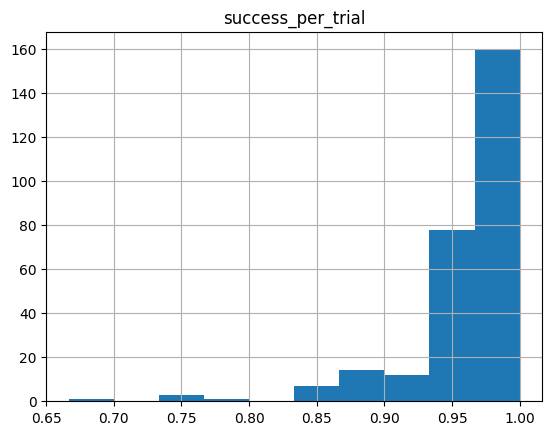

In [49]:
success_per_trial.hist(column='success_per_trial',bins=10)

### 2.3. Single Steps Response-Time Within Subject

In [ ]:
# calculating response time quantiles and IQR per subject
quantiles_per_subject = response_times[['rt', 'subject']].groupby('subject').quantile([0.25, 0.75]).unstack()
quantiles_per_subject.columns = ['q1', 'q3']
quantiles_per_subject['iqr'] = quantiles_per_subject['q3'] - quantiles_per_subject['q1']

quantiles_per_subject.head(3)

,q1,q3,iqr
subject,,,
101B,1207.0,2550.50,1343.50
102A,1245.0,3497.75,2252.75
102B,1045.0,2832.50,1787.50


In [ ]:
# finding if a step is an outlier in terms of response time within subject
def is_subjective_outlier(step):
    rt = step['rt']
    subject = step['subject']
        
    subject_quantiles = quantiles_per_subject.loc[subject]
    q1, q3, iqr = subject_quantiles['q1'], subject_quantiles['q3'], subject_quantiles['iqr']
    return is_outlier(rt, q1, q3, iqr, 2)

In [ ]:
# filtering only outliers
subjective_outlier_mask = response_times.apply(is_subjective_outlier, axis=1)
outlier_steps = response_times[subjective_outlier_mask]

In [ ]:
outlier_steps = outlier_steps.merge(quantiles_per_subject, how='left', left_on='subject', right_index=True)
outlier_steps.head()

,subject,step_num,rt,q1,q3,iqr
441,107B,441,4779,543.50,1825.75,1282.25
892,104B,430,5978,380.25,1829.50,1449.25
1147,106B,229,8350,824.25,3001.25,2177.00
1383,105B,7,8432,1464.00,3129.75,1665.75
1483,105B,107,7764,1464.00,3129.75,1665.75
